# Get multibolid data



In [3]:
from MLABvo.Bolidozor import Bolidozor
import json
import datetime
import numpy as np
import scipy.signal
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import dates
import sys
sys.path.append("..") 
import recviewer
import dateutil.parser

%matplotlib inline 

# Inicializace bolidozoru

Funkce ```Bolidozor.getMultibolid``` jako jediný parametr bere id skupiny, které lze zjistit například zde: http://rtbolidozor.astro.cz/multibolid/

In [38]:
multibolid_id = 1503331

In [51]:
bz = Bolidozor()
bolids = bz.getMultibolid(id=multibolid_id)
print('Počet detekcí ve skupině je',len(bolids.result))

Počet detekcí ve skupině je 5


Získaná data z MLABvo jsou k dispozici v ```Bolidozor.getMultibolid.result```.

Následující buňka ukazuje, jak lze procházet záznamy po jednom.

**Výsledek obsahuje následující informace**

In [52]:
print(list(bolids.result[0].keys()))
print("")
print(bolids.result[0])

['url_file', 'namesimple', 'filepath', 'url_station', 'id_observer', 'file_status', 'event_id', 'url_file_raw', 'url_file_js9', 'observatory_name', 'observatory_namesimple', 'peak_f', 'magnitude', 'station_name', 'duration', 'filename_raw', 'id_server', 'obstime', 'filename', 'noise']

{'url_file': 'http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/25/10/20170925104720356_VALMEZ-R1_met.fits', 'namesimple': 'VALMEZ-R1', 'filepath': '/storage/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/25/10', 'url_station': 'http://api.vo.astro.cz/bolidozor/getStation/?id=30', 'id_observer': 30, 'file_status': 'online', 'event_id': 927079, 'url_file_raw': 'http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/25/10/20170925104720356_VALMEZ-R1_raws.fits', 'url_file_js9': 'http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/25/10/20170925104720356_VALMEZ-R1_met.fits', 'observatory_name': 'valmez', 'observatory_namesimple': 'valmez', 'pea

Nahrát data do cache

In [53]:
for i, bolid in enumerate(bolids.result):
    print(i+1,'z',len(bolids.result))
    fits.open(bolid['url_file_raw'])

1 z 5
2 z 5
3 z 5
4 z 5
5 z 5


# Kalibrace času

tato funkce projde RAW soubory a snaží se v nich vyhledat GPS značku. 

Výstupem této funkce je ```dictionary```, který obsahuje informace o času na začátku souboru, času konce souboru a prvního vzorku s GPS značkou ze systémového času stanice. Tyto samé časy vrací taktéž oproti GPS času.


In [54]:
def timeCalibration(raw_file, sigma = 15, debug = True):
    calibration_data = {}
    hdulist = fits.open(raw_file, cache=True)
    met_data = np.abs(np.ravel(hdulist[0].data))
    clip_val = np.std(met_data)*sigma
    plt.axhline(y=clip_val, color='red')
    max_val = np.max(met_data)
    for i, point in enumerate(met_data):
        if point > clip_val:
            plt.axvline(x=i, color='red')
            ten_sec = 10/(hdulist[0].header['CDELT2']/2/1000.0)
            if debug: plt.axvline(x=i+ten_sec, color='green')
            break
    #file_length = hdulist[0].header['NAXIS2']*hdulist[0].header['CDELT2']/1000.0
    file_length = hdulist[0].header['NAXIS2']*1/96000
    time_firstGPS = i/2*1/96000
    DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
    DATE = datetime.datetime.strptime(hdulist[0].header['DATE'], "%Y-%m-%dT%H:%M:%S" )
    
    gps = (DATE-datetime.timedelta(seconds=file_length-time_firstGPS)).timestamp()
    round_gps = round(gps/10.0)*10
    correction = datetime.timedelta(seconds=round_gps-gps)

    calibration_data['sys_correction'] = correction
    
    calibration_data['sys_file_beg'] = DATE-datetime.timedelta(seconds=file_length)
    calibration_data['sys_file_end'] = DATE
    calibration_data['sys_1st_GPS'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)
    calibration_data['sys_error'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)
    
    calibration_data['cor_file_beg'] = DATE-datetime.timedelta(seconds=file_length)+correction
    calibration_data['cor_file_end'] = DATE+correction
    calibration_data['cor_1st_GPS'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)+correction
    calibration_data['cor_error'] = correction
    
    if debug:
        #DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
        print("Zpracovavam soubor:", raw_file)
        print('delka zaznamu          :', file_length, "s")
        print('cas prvni vzorku s GPS :', time_firstGPS, "s")
        print('cas 1. GPS a konec     :', file_length - time_firstGPS, "s")
        print('SysCas ukladani souboru:', calibration_data['sys_file_end'], "s")
        print('SysCas zacatku souboru :', calibration_data['sys_file_beg'])
        print('SysCas 1. GPS znacky   :', calibration_data['sys_1st_GPS'])
        print('Korekce systémoveho čas:', correction)
        print('CorCas ukladani souboru:', calibration_data['cor_file_end'], "s")
        print('CorCas zacatku souboru :', calibration_data['cor_file_beg'])
        print('CorCas 1. GPS znacky   :', calibration_data['cor_1st_GPS'])
        plt.plot(met_data)
        plt.show()
    return calibration_data
        

Tato smyčka projde všechny soubory a použije na nich funkci pro kalibraci času. Výstup přidá do původní proměnné pod klíčem ```time_calib```.

Pokud je zapnuté debugování, tak ze skriptu vypadávají tato data:

delka zaznamu          : Délka záznamu
cas prvni vzorku s GPS : 
cas 1. GPS a konec     : Vzdálenost první detekované GPS ke konci souboru
SysCas ukladani souboru: Čas z hlavičky FITSu ['DATE']
SysCas zacatku souboru : Čas z hlavičky ['DATE'] mínus délka souboru
SysCas 1. GPS znacky   : Systémový čas stanice v okamžiku GPS značky
Korekce systémoveho čas: Systémový čas 
CorCas ukladani souboru: 2017-09-23 07:24:19.241618 s
CorCas zacatku souboru : 2017-09-23 07:24:06.241614
CorCas 1. GPS znacky   : 2017-09-23 07:24:10

0 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/25/10/20170925104720356_VALMEZ-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/25/10/20170925104720356_VALMEZ-R1_raws.fits
delka zaznamu          : 6.6 s
cas prvni vzorku s GPS : 1.5725416666666667 s
cas 1. GPS a konec     : 5.027458333333333 s
SysCas ukladani souboru: 2017-09-25 10:47:04 s
SysCas zacatku souboru : 2017-09-25 10:46:57.400000
SysCas 1. GPS znacky   : 2017-09-25 10:46:58.972542
Korekce systémoveho čas: 0:00:01.027458
CorCas ukladani souboru: 2017-09-25 10:47:05.027458 s
CorCas zacatku souboru : 2017-09-25 10:46:58.427458
CorCas 1. GPS znacky   : 2017-09-25 10:47:00


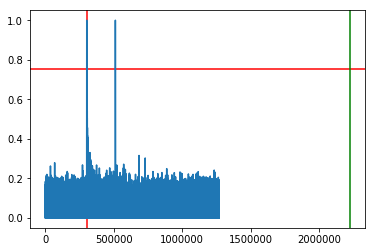

1 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/HFN/HFN-R1/meteors/2017/09/25/10/20170925104659990_HFN-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/HFN/HFN-R1/meteors/2017/09/25/10/20170925104659990_HFN-R1_raws.fits
delka zaznamu          : 11.8 s
cas prvni vzorku s GPS : 1.2625 s
cas 1. GPS a konec     : 10.537500000000001 s
SysCas ukladani souboru: 2017-09-25 10:47:05 s
SysCas zacatku souboru : 2017-09-25 10:46:53.200000
SysCas 1. GPS znacky   : 2017-09-25 10:46:54.462500
Korekce systémoveho čas: -1 day, 23:59:55.537500
CorCas ukladani souboru: 2017-09-25 10:47:00.537500 s
CorCas zacatku souboru : 2017-09-25 10:46:48.737500
CorCas 1. GPS znacky   : 2017-09-25 10:46:50


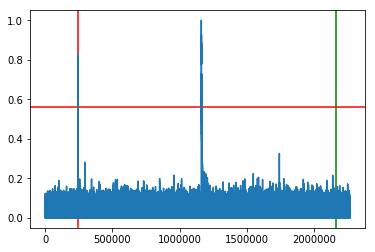

2 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/25/10/20170925104645063_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/25/10/20170925104645063_SVAKOV-R12_raws.fits
delka zaznamu          : 14.6 s
cas prvni vzorku s GPS : 7.3159375 s
cas 1. GPS a konec     : 7.284062499999999 s
SysCas ukladani souboru: 2017-09-25 10:47:05 s
SysCas zacatku souboru : 2017-09-25 10:46:50.400000
SysCas 1. GPS znacky   : 2017-09-25 10:46:57.715938
Korekce systémoveho čas: 0:00:02.284062
CorCas ukladani souboru: 2017-09-25 10:47:07.284062 s
CorCas zacatku souboru : 2017-09-25 10:46:52.684062
CorCas 1. GPS znacky   : 2017-09-25 10:47:00


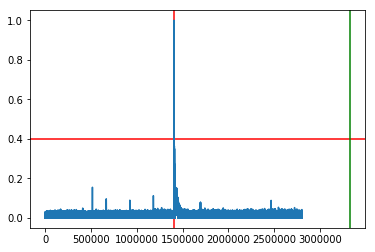

3 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/25/10/20170925104726686_DDMTREBIC-R3_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/25/10/20170925104726686_DDMTREBIC-R3_raws.fits
delka zaznamu          : 9.199989583333334 s
cas prvni vzorku s GPS : 3.9488385416666665 s
cas 1. GPS a konec     : 5.251151041666668 s
SysCas ukladani souboru: 2017-09-25 10:47:05 s
SysCas zacatku souboru : 2017-09-25 10:46:55.800010
SysCas 1. GPS znacky   : 2017-09-25 10:46:59.748849
Korekce systémoveho čas: 0:00:00.251151
CorCas ukladani souboru: 2017-09-25 10:47:05.251151 s
CorCas zacatku souboru : 2017-09-25 10:46:56.051161
CorCas 1. GPS znacky   : 2017-09-25 10:47:00


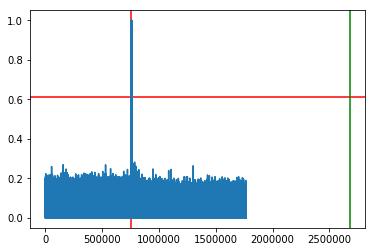

4 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/CIIRC/CIIRC-R1/meteors/2017/09/25/10/20170925104731735_CIIRC-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/CIIRC/CIIRC-R1/meteors/2017/09/25/10/20170925104731735_CIIRC-R1_raws.fits
delka zaznamu          : 12.2 s
cas prvni vzorku s GPS : 5.814895833333333 s
cas 1. GPS a konec     : 6.385104166666666 s
SysCas ukladani souboru: 2017-09-25 10:47:05 s
SysCas zacatku souboru : 2017-09-25 10:46:52.800000
SysCas 1. GPS znacky   : 2017-09-25 10:46:58.614896
Korekce systémoveho čas: 0:00:01.385104
CorCas ukladani souboru: 2017-09-25 10:47:06.385104 s
CorCas zacatku souboru : 2017-09-25 10:46:54.185104
CorCas 1. GPS znacky   : 2017-09-25 10:47:00


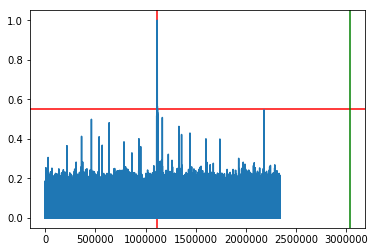

In [55]:

for i, bolid in enumerate(bolids.result):
    print(i,"==================================")
    print("snapshot:", bolid['url_file_js9'])
    bolids.result[i]['time_calib']=timeCalibration(bolid['url_file_raw'])
    

# Filtr nevyhovujících dat

Protože v některých datech nemusí být dobře detekovatelná GPS značka, je zde možné tyto soubory ručně vyřadit. A to tím, že odkomentujete druhý řádek následující buňky a do seznamu napíšete čísla vyhovujících RAW souborů. (Jsou k nalezení ve výstupu předchozí buňky)

In [60]:
time_offset = {}
selected = list(range(0, len(bolids.result)))     # vyber vsech dat

#selected.remove(0)
selected.remove(1)
#selected.remove(4)
#selected = [0,1,2,3,6]

#selected = [3,4,5,6]     #Pokud chcete vybrat konkrétní data, 
                               #odkomentujte tento řádek a vložte do něj čísla požadovaných dat

# time_offset[0] = +0   ## Posun času na stanici.
                        # Timto posunete data pro určitou stanici (podle indexu souboru)
                        # o určitý počet časových značek (10s intervalů)
                        # Kladné číslo posune graf 'nahoru" 
#time_offset[3]=0.5
#time_offset[4]=0.5
#time_offset[1]=1
for i, bolid in enumerate(bolids.result):
    if i in selected:
        print(i, ',sysT of gps:', bolid['time_calib']['cor_1st_GPS'], ',offset:', bolid['time_calib']['cor_error'], bolid['filename'])

0 ,sysT of gps: 2017-09-25 10:47:00 ,offset: 0:00:01.027458 20170925104720356_VALMEZ-R1_met.fits
2 ,sysT of gps: 2017-09-25 10:47:00 ,offset: 0:00:02.284062 20170925104645063_SVAKOV-R12_met.fits
3 ,sysT of gps: 2017-09-25 10:47:00 ,offset: 0:00:00.251151 20170925104726686_DDMTREBIC-R3_met.fits
4 ,sysT of gps: 2017-09-25 10:47:00 ,offset: 0:00:01.385104 20170925104731735_CIIRC-R1_met.fits


# Zarovnané soubory

Toto je první buňka, jejíž výstup obsahuje časově zarovnané grafy. Pomocí proměnné ```gps_calib``` můžete nastavit, zdali Vaše zarovnání bude oproti absolutním GPS značkám (```gps_calib=True```) nebo oproti systémovému času stanic (```gps_calib=False```).

0 2017-09-25 10:46:58.427458
1 2017-09-25 10:46:52.684062
2 2017-09-25 10:46:56.051161
3 2017-09-25 10:46:54.185104
1506336412.684062 1506336427.284062


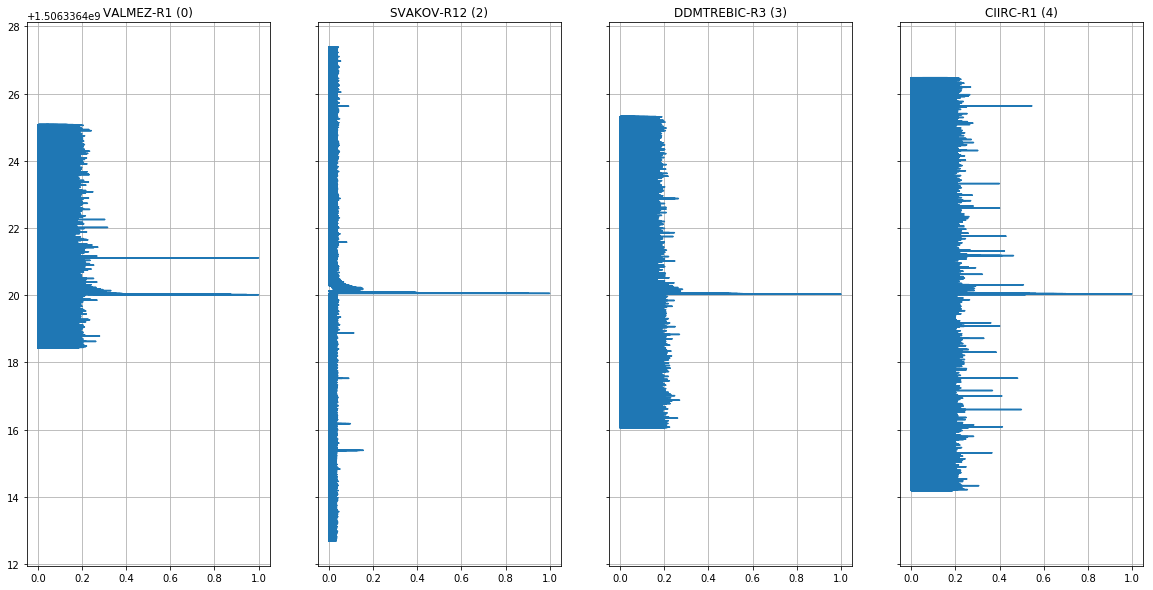

In [61]:
%matplotlib inline 
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

gps_calib = True
minimal_time = None
maximal_time = None

for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    print (i, bolid['time_calib']['cor_file_beg'])
    hdulist = fits.open(bolid['url_file_raw'])
    met_data = np.abs(np.ravel(hdulist[0].data))
    
    T_offset = 10*time_offset.get(selected[i], 0)
    
    if gps_calib:
        min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    else:
        min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))
    
    if not minimal_time: minimal_time = min_date
    if not maximal_time: maximal_time = max_date
    if min_date < minimal_time: minimal_time = min_date
    if max_date > maximal_time: maximal_time = max_date
    
    ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+")")
    ax.plot(met_data, array)
    ax.grid(True)

fig.subplots_adjust(hspace=0)
print(minimal_time, maximal_time)

In [62]:
def waterfall(signal, sample_rate=None, bins = 4096 ):
    waterfall = recviewer.waterfallize(signal, bins)
    waterfall[np.isneginf(waterfall)] = np.nan
    wmin, wmax = np.nanmin(waterfall), np.nanmax(waterfall)
    return waterfall

{}


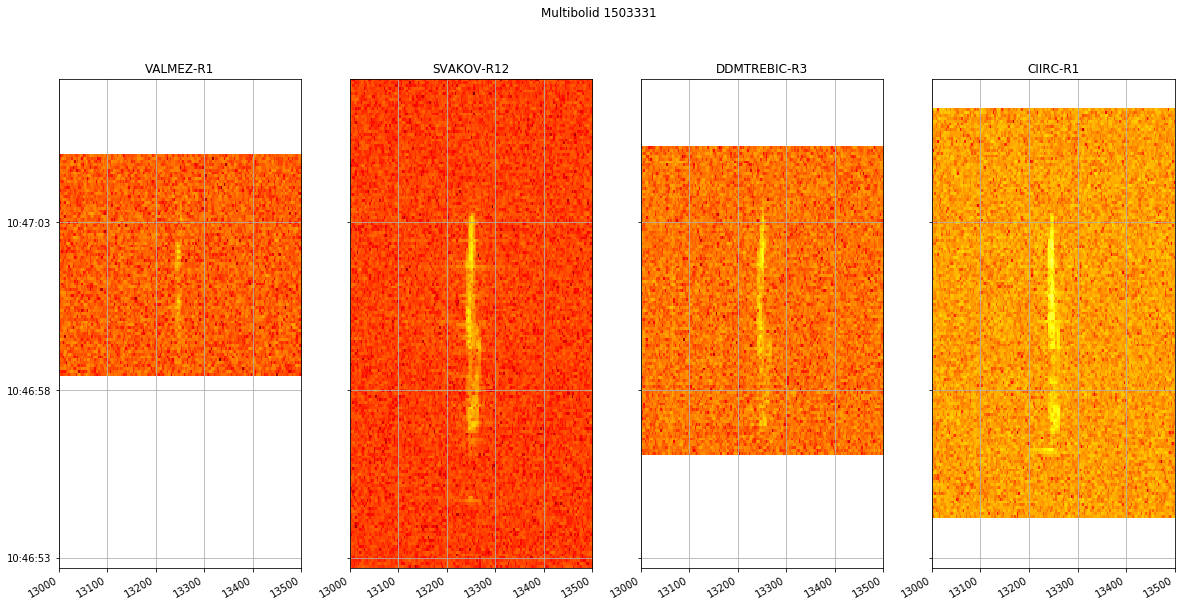

In [63]:
%matplotlib inline 
#%matplotlib notebook
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

print(time_offset)
fig.suptitle("Multibolid %s" %(multibolid_id))
fig.subplots_adjust(hspace=0)
plt.set_cmap('hot')
for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    hdu = fits.open(bolid['url_file_raw'])[0]
    flat_data = np.ravel(hdu.data)
    
    T_offset = datetime.timedelta(seconds = 10*time_offset.get(selected[i], 0))
    #print(i, selected[i], bolid['time_calib']['cor_file_beg'], bolid['time_calib']['cor_file_beg']+T_offset, T_offset)
    d1 = bolid['time_calib']['cor_file_beg']+T_offset
    fds1 = dates.date2num(d1) # converted
    d2 = d1 + datetime.timedelta(seconds=hdu.header['NAXIS2']/48000.0/2)
    fds2 = dates.date2num(d2)
    
    arr = waterfall(flat_data[0::2] + 1j * flat_data[1::2], 48000, bins = 4096*4)
    ax.imshow(arr,  interpolation='none', aspect='auto',  extent=[-24000, 24000, fds2, fds1])
    ax.grid(True)
    
    ax.set_xlim(13000,13500)
    ax.yaxis_date()
    date_format = md.DateFormatter('%H:%M:%S')
    ax.yaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    ax.set_ylim( datetime.datetime.utcfromtimestamp(minimal_time), datetime.datetime.utcfromtimestamp(maximal_time))
    
    offset = abs(bolid['time_calib']['cor_error']).microseconds/1000000 + abs(bolid['time_calib']['cor_error']).seconds
    if bolid['time_calib']['cor_error'] < datetime.timedelta(seconds=0): offset = -offset
    #ax.set_title(bolid['namesimple']+ " err:"+str(offset))
    ax.set_title(bolid['namesimple'])
